# Demixing Components and Recovering Correlation Structure

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import time, os
import matplotlib.pyplot as plt
import numpy as np
import superpixel_analysis as sup
import util_plot

from skimage import io

import scipy.io
from scipy.ndimage import center_of_mass

## Read in movie

(88, 236, 89899)


/n/home00/mxie/.conda/envs/michaelxie/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


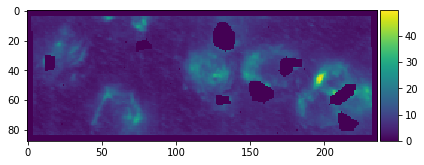

In [2]:
# input movie path
Parent = '/n/cohen_lab/Lab/Labmembers/Yoav Adam/Data/In Vivo';
Project = '/PlaceCells';
Mouse='/PC5-X';
Session = '/2019-05-30_PC5-X-S5';
FOV= '2';
Trial = '/190530150538_FreeRun90_10V';
path = (Parent + Project + Mouse + Session + '/FOV' + FOV + Trial + '/PMD_output');

# read in motion corrected movie
noise = np.squeeze(io.imread(path + '/Sn_image.tif'))
[nrows, ncols] = noise.shape

if os.path.isfile(path + '/motion_corrected.bin'):
    mov = np.fromfile(path + '/motion_corrected.bin',dtype=np.float32)
    mov = np.reshape(mov,(-1, ncols, nrows)).transpose(2,1,0)
elif os.path.isfile(path + '/denoised.tif'):
    mov = io.imread(path + '/denoised.tif')
else:
    raise ValueError('No valid input file')

# read in the mask for blood
if os.path.isfile(path + '/bloodmask.tif'):
    bloodmask = np.squeeze(io.imread(path + '/bloodmask.tif'))
    mov = mov * np.repeat(np.expand_dims(noise * bloodmask,2),mov.shape[2],axis=2)
else:
    mov = mov * np.repeat(np.expand_dims(noise,2),mov.shape[2],axis=2)

# display average movie
print(mov.shape)
io.imshow(np.std(mov,axis=2))

## Spatial 2x2 Binning

/n/home00/mxie/.conda/envs/michaelxie/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


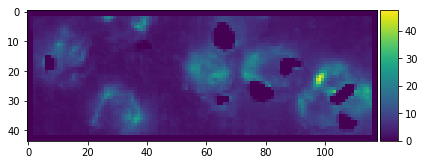

In [3]:
movB = mov.reshape(int(mov.shape[0]/2),2,int(mov.shape[1]/2),2,mov.shape[2])
movB = np.mean(np.mean(movB,axis=1),axis=2)
movB.shape

# show standard deviation image of binned movie
io.imshow(np.std(movB,axis=2))

## Load Manually Initialized Background

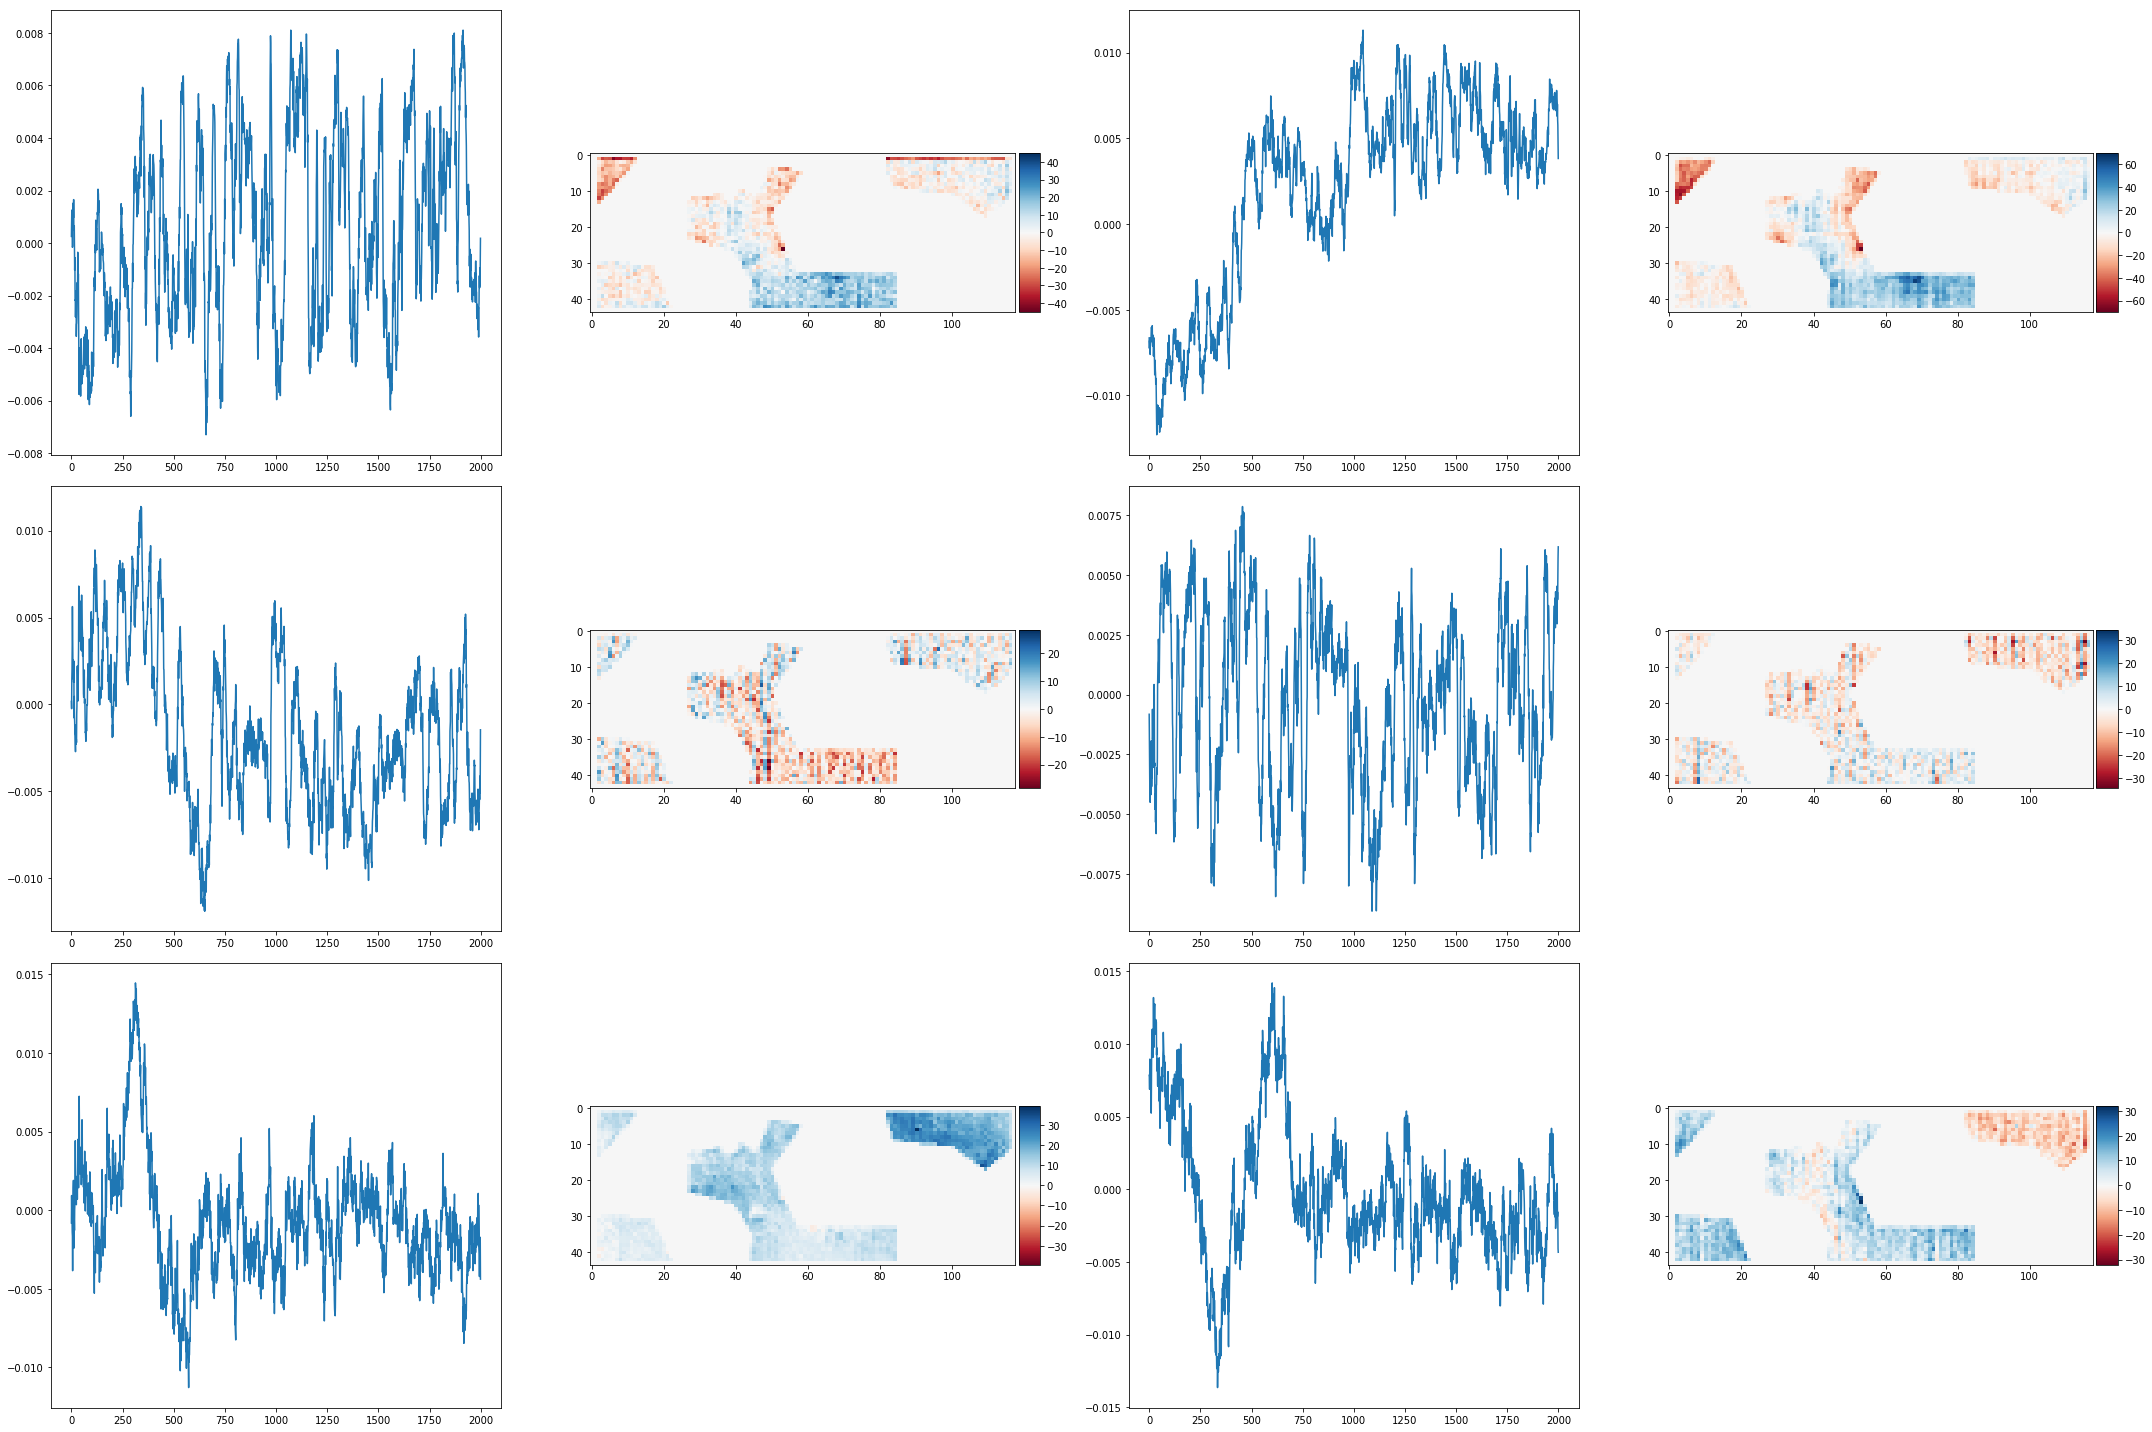

In [4]:
bg_flag = os.path.isfile(path + '/ff.tif');

if bg_flag:
    # import manually initialized background components
    ff_ini = io.imread(path + '/ff.tif')
    fb_ini = io.imread(path + '/fb.tif')

    # bin the spatial components
    fb_ini = fb_ini.reshape(mov.shape[1],mov.shape[0],-1).transpose(1,0,2)
    fb_ini = fb_ini.reshape(int(fb_ini.shape[0]/2),2,int(fb_ini.shape[1]/2),2,fb_ini.shape[2])
    fb_ini = np.mean(np.mean(fb_ini,axis=1),axis=2)

    fb_ini.shape

    # plot manually initialized background components
    plt.figure(figsize=(30,20))

    for i in range(6):
        plt.subplot(3,4,2*i+1)
        plt.plot(ff_ini[:2000,i])
        plt.subplot(3,4,2*i+2)
        io.imshow(fb_ini[:,:,i])

In [5]:
if bg_flag:
    # select which background components to use for initialization
    bkg_components = range(6)

    fb_ini = fb_ini[:,:,bkg_components].reshape(movB.shape[0]*movB.shape[1],len(bkg_components))
    ff_ini = ff_ini[:,bkg_components]

## Get Cell Spatial Supports from High Pass Filtered Movie

In [6]:
start = time.time()

# select which window to demix on
first_frame = 5000
last_frame = 15000

movHP = sup.hp_filt_data(movB,spacing=10)

rlt=sup.axon_pipeline_Y(movHP[:,:,first_frame:last_frame].copy(), fb_ini = np.zeros(1), ff_ini = np.zeros(1),
                        
                        ##### Superpixel parameters
                        # thresholding level
                        th = [4],
                        
                        # correlation threshold for finding superpixels
                        # (range around 0.8-0.99)
                        cut_off_point = [0.97], 
                        
                        # minimum pixel count of a superpixel
                        # don't need to change these unless cell sizes change
                        length_cut = [10],
                        
                        # maximum pixel count of a superpixel
                        # don't need to change these unless cell sizes change
                        length_max = [1000], 
                       
                        patch_size = [30,30], 
                        
                        # correlation threshold between superpixels for merging
                        # likely don't need to change this
                        residual_cut = [np.sqrt(1-(0.8)**2)],
                        
                        pass_num = 1, bg = False, 
                        
                        ##### Cell-finding, NMF parameters
                        # correlation threshold of pixel with superpixel trace to include pixel in cell
                        # (range 0.3-0.6)
                        corr_th_fix = 0.5,
                        
                        # correlation threshold for merging two cells
                        # (default 0.8, but likely don't need to change)
                        merge_corr_thr = 0.6, 
                        
                        ##### Other options
                        # if True, only superpixel analysis run; if False, NMF is also run to find cells
                        sup_only = False,
                        
                        # the number of superpixels to remove (starting from the dimmest)
                        remove = 0
                       )

print("Demixing took: " + str(time.time()-start)+" sec")

start 1 pass!
find superpixels!


/n/home00/mxie/Projects/invivo-imaging-develop/demix/superpixel_analysis.py:299: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Yt.transpose(2,0,1) - np.mean(Yt, axis=2)) / np.std(Yt, axis=2);


5.960185527801514
rank 1 svd!
2.0891575813293457
find pure superpixels!
0.04046320915222168
prepare iteration!
1.070481300354004
5.084558010101318
start 1 pass iteration!
a.shape = (5192, 7); c.shape = (10000, 7)


/n/home00/mxie/Projects/invivo-imaging-develop/demix/superpixel_analysis.py:2237: RuntimeWarning: divide by zero encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);
/n/home00/mxie/Projects/invivo-imaging-develop/demix/superpixel_analysis.py:2237: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);


time: 2.9489657878875732
time: 2.2896487712860107
time: 2.306351900100708


/n/home00/mxie/Projects/invivo-imaging-develop/demix/superpixel_analysis.py:2259: RuntimeWarning: divide by zero encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);
/n/home00/mxie/Projects/invivo-imaging-develop/demix/superpixel_analysis.py:2259: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);
/n/home00/mxie/Projects/invivo-imaging-develop/demix/superpixel_analysis.py:2177: RuntimeWarning: invalid value encountered in greater
  cor = csc_matrix((corr_img_all_r>merge_corr_thr)*1);


no merge!
time: 10.625243663787842
time: 2.527189254760742
time: 2.3476905822753906
time: 2.897362232208252
no merge!
time: 10.443958044052124
time: 2.6234893798828125
time: 2.3020987510681152
time: 2.2906417846679688
no merge!
time: 10.66905665397644
time: 2.3435306549072266
time: 2.6170339584350586
time: 2.3084542751312256
no merge!
time: 10.92768669128418
time: 2.5635826587677
time: 2.4223217964172363
time: 2.9341962337493896
no merge!
time: 10.493498802185059
time: 2.6347005367279053
time: 2.305363178253174
time: 2.288766860961914
no merge!
time: 10.743407726287842
time: 2.4344446659088135
time: 2.5727429389953613
time: 2.3212828636169434
no merge!
time: 10.908551931381226
time: 2.4470224380493164
time: 2.853710412979126
time: 2.4288575649261475
no merge!
time: 10.68911361694336
time: 2.612715482711792
time: 2.312316656112671
time: 2.2992522716522217
no merge!
time: 10.873421669006348
time: 2.9773802757263184
time: 2.3535687923431396
time: 2.297981023788452
no merge!
time: 10.59198

/n/home00/mxie/.conda/envs/michaelxie/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


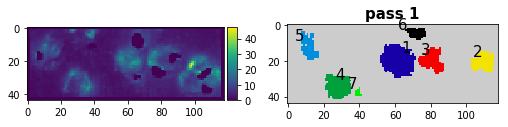

In [7]:
# plot pure superpixels

num_pass = len(rlt["superpixel_rlt"])
    
scale = np.maximum(1, (rlt["superpixel_rlt"][0]["connect_mat_1"].shape[1]/rlt["superpixel_rlt"][0]["connect_mat_1"].shape[0]));
fig = plt.figure(figsize=(4*scale*num_pass,4))

plt.subplot(1,num_pass+2,1);
io.imshow(np.std(movB,axis=2));

for p in range(num_pass):
    connect_mat_1 = rlt["superpixel_rlt"][p]["connect_mat_1"]
    pure_pix = rlt["superpixel_rlt"][p]["pure_pix"]
    brightness_rank = rlt["superpixel_rlt"][p]["brightness_rank"]
    ax1 = plt.subplot(1,num_pass+2,p+2);
    dims = connect_mat_1.shape;
    connect_mat_1_pure = connect_mat_1.copy();
    connect_mat_1_pure = connect_mat_1_pure.reshape(np.prod(dims),order="F");
    connect_mat_1_pure[~np.in1d(connect_mat_1_pure,pure_pix)]=0;
    connect_mat_1_pure = connect_mat_1_pure.reshape(dims,order="F");

    ax1.imshow(connect_mat_1_pure,cmap="nipy_spectral_r");

    for ii in range(len(pure_pix)):
        pos = np.where(connect_mat_1_pure[:,:] == pure_pix[ii]);
        pos0 = pos[0];
        pos1 = pos[1];
        ax1.text((pos1)[np.array(len(pos1)/3,dtype=int)], (pos0)[np.array(len(pos0)/3,dtype=int)], f"{brightness_rank[ii]+1}",
            verticalalignment='bottom', horizontalalignment='right',color='black', fontsize=15)#, fontweight="bold")
    
    ax1.set(title="pass " + str(p+1))
    ax1.title.set_fontsize(15)
    ax1.title.set_fontweight("bold");
    plt.tight_layout();

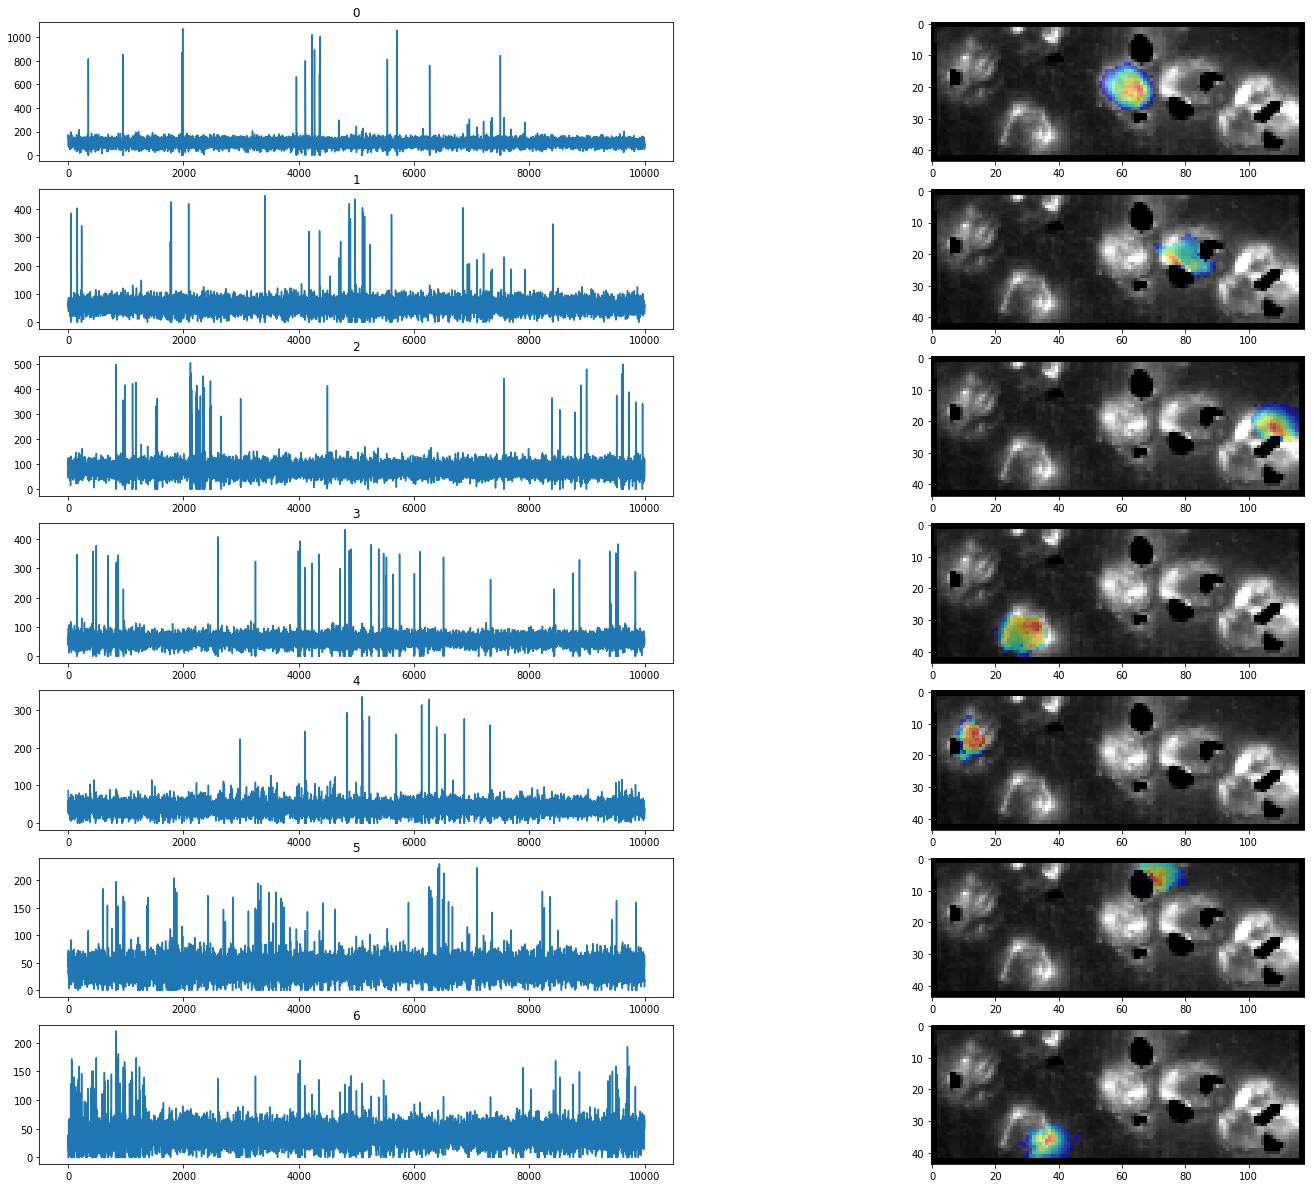

In [8]:
# plot all cell traces and footprints from NMF
cell_ct = rlt["fin_rlt"]["c"].shape[1]

plt.figure(figsize=(25,3*cell_ct))
    
ref_im = np.std(movB,axis=2)#.transpose(1,0)

for cell_num in range(cell_ct):
    plt.subplot(cell_ct,2,2*cell_num+1)
    plt.plot(rlt["fin_rlt"]["c"][:,cell_num])
    plt.title(cell_num)
    
    plt.subplot(cell_ct,2,2*cell_num+2)
    lower,upper = np.percentile(ref_im.flatten(),[1, 99])
    plt.imshow(ref_im,cmap='gray',interpolation='none',clim=[lower,upper])
    
    cell_loc = rlt["fin_rlt"]["a"][:,cell_num].reshape(movB.shape[1],movB.shape[0]).transpose(1,0)
    cell_loc = np.ma.masked_where(cell_loc == 0, cell_loc)
    plt.imshow(cell_loc,cmap='jet',alpha=0.5)

In [9]:
proc = input('Ok to proceed? (y/n) ')

if proc.lower() == 'n':
    raise KeyboardInterrupt('Stop requested by user.')

Ok to proceed? (y/n) y


## Get Background Components from Unfiltered Movie

In [10]:
# rank of background to model, if none selected
bg_rank = 6;

a = rlt["fin_rlt"]["a"].copy();
c = rlt["fin_rlt"]["c"].copy();
b = rlt["fin_rlt"]["b"].copy();

dims = movB.shape[:2];
T = last_frame - first_frame;

if bg_flag:
    fb = fb_ini;
    ff = ff_ini[first_frame:last_frame,:];
    bg_rank = fb.shape[1]
else:    
    fb = np.random.rand(np.prod(dims),bg_rank);
    ff = np.ones((T,bg_rank));

movVec = movB.reshape(np.prod(dims),-1,order="F");
mov_min = movVec.min();
if mov_min < 0:
    mov_min_pw = movVec.min(axis=1,keepdims=True);
    movVec -= mov_min_pw;

normalize_factor = np.std(movVec,axis=1,keepdims=True)*T

a, c, b, fb, ff, res, \
corr_img_all_r, num_list = \
sup.update_AC_bg_l2_Y(movVec[:,first_frame:last_frame].copy(),normalize_factor, a, c, b, ff, fb, dims,
                      corr_th_fix=0.35,
                      maxiter=35, tol=1e-8,
                      merge_corr_thr=0.8,
                      merge_overlap_thr=0.8, keep_shape=True
                     );


/n/home00/mxie/Projects/invivo-imaging-develop/demix/superpixel_analysis.py:2319: RuntimeWarning: invalid value encountered in true_divide
  corr_img_all = vcorrcoef_Y(U/normalize_factor, c);


time: 2.1129047870635986
time: 2.0669610500335693
time: 2.083622932434082
time: 2.069850206375122
time: 2.4931557178497314
time: 2.0879411697387695
time: 2.0541467666625977
time: 2.2725000381469727
time: 2.0708940029144287
time: 2.076650619506836
time: 2.6204659938812256
time: 2.1037826538085938
time: 2.0442211627960205
time: 2.0974032878875732
time: 2.0872538089752197
time: 2.601426124572754
time: 2.1944494247436523
time: 2.0815181732177734
time: 2.079345941543579
time: 2.067209005355835
time: 2.062675714492798
time: 2.379047393798828
time: 2.082152843475342
time: 2.082899808883667
time: 2.0820133686065674
time: 2.0562191009521484
time: 2.0724987983703613
time: 2.49652361869812
time: 2.1142916679382324
time: 2.111884355545044
time: 2.0482492446899414
time: 2.089980125427246
time: 2.5893173217773438
time: 2.103724718093872
time: 2.055107355117798


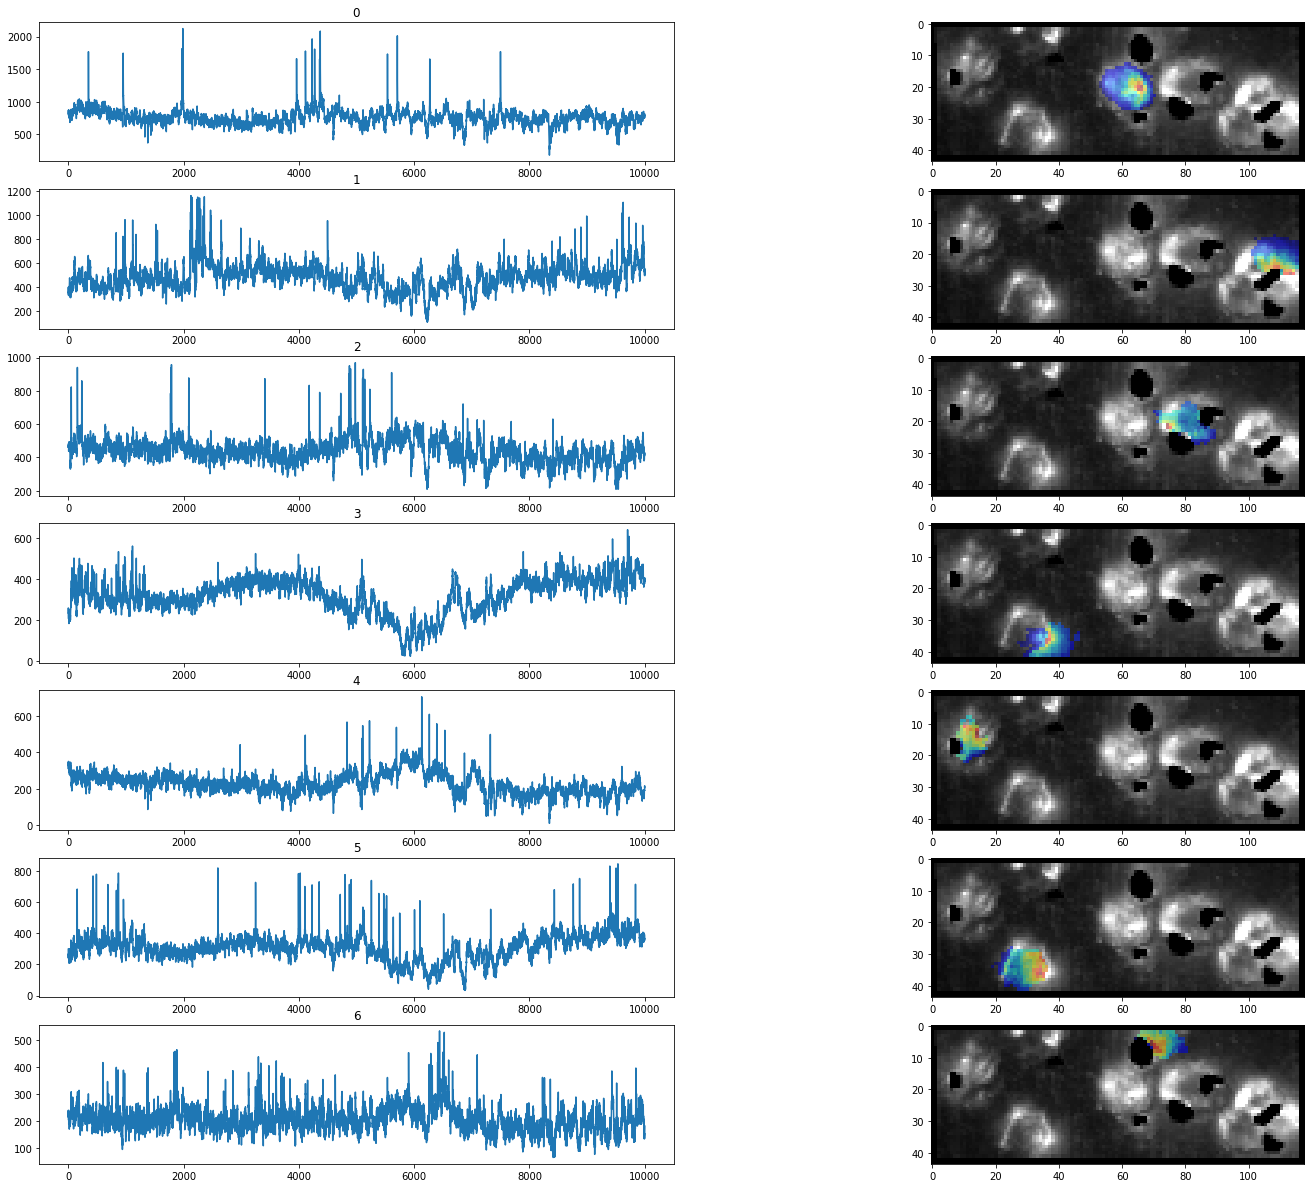

In [11]:
# plot all cell traces and footprints
cell_ct = c.shape[1]

plt.figure(figsize=(25,3*cell_ct))
    
ref_im = np.std(movB,axis=2)#.transpose(1,0)

for cell_num in range(cell_ct):
    plt.subplot(cell_ct,2,2*cell_num+1)
    plt.plot(c[:,cell_num])
    plt.title(cell_num)
    
    plt.subplot(cell_ct,2,2*cell_num+2)
    lower,upper = np.percentile(ref_im.flatten(),[1, 99])
    plt.imshow(ref_im,cmap='gray',interpolation='none',clim=[lower,upper])
    
    cell_loc = a[:,cell_num].reshape(movB.shape[1],movB.shape[0]).transpose(1,0)
    cell_loc = np.ma.masked_where(cell_loc == 0, cell_loc)
    plt.imshow(cell_loc,cmap='jet',alpha=0.5)

/n/home00/mxie/.conda/envs/michaelxie/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


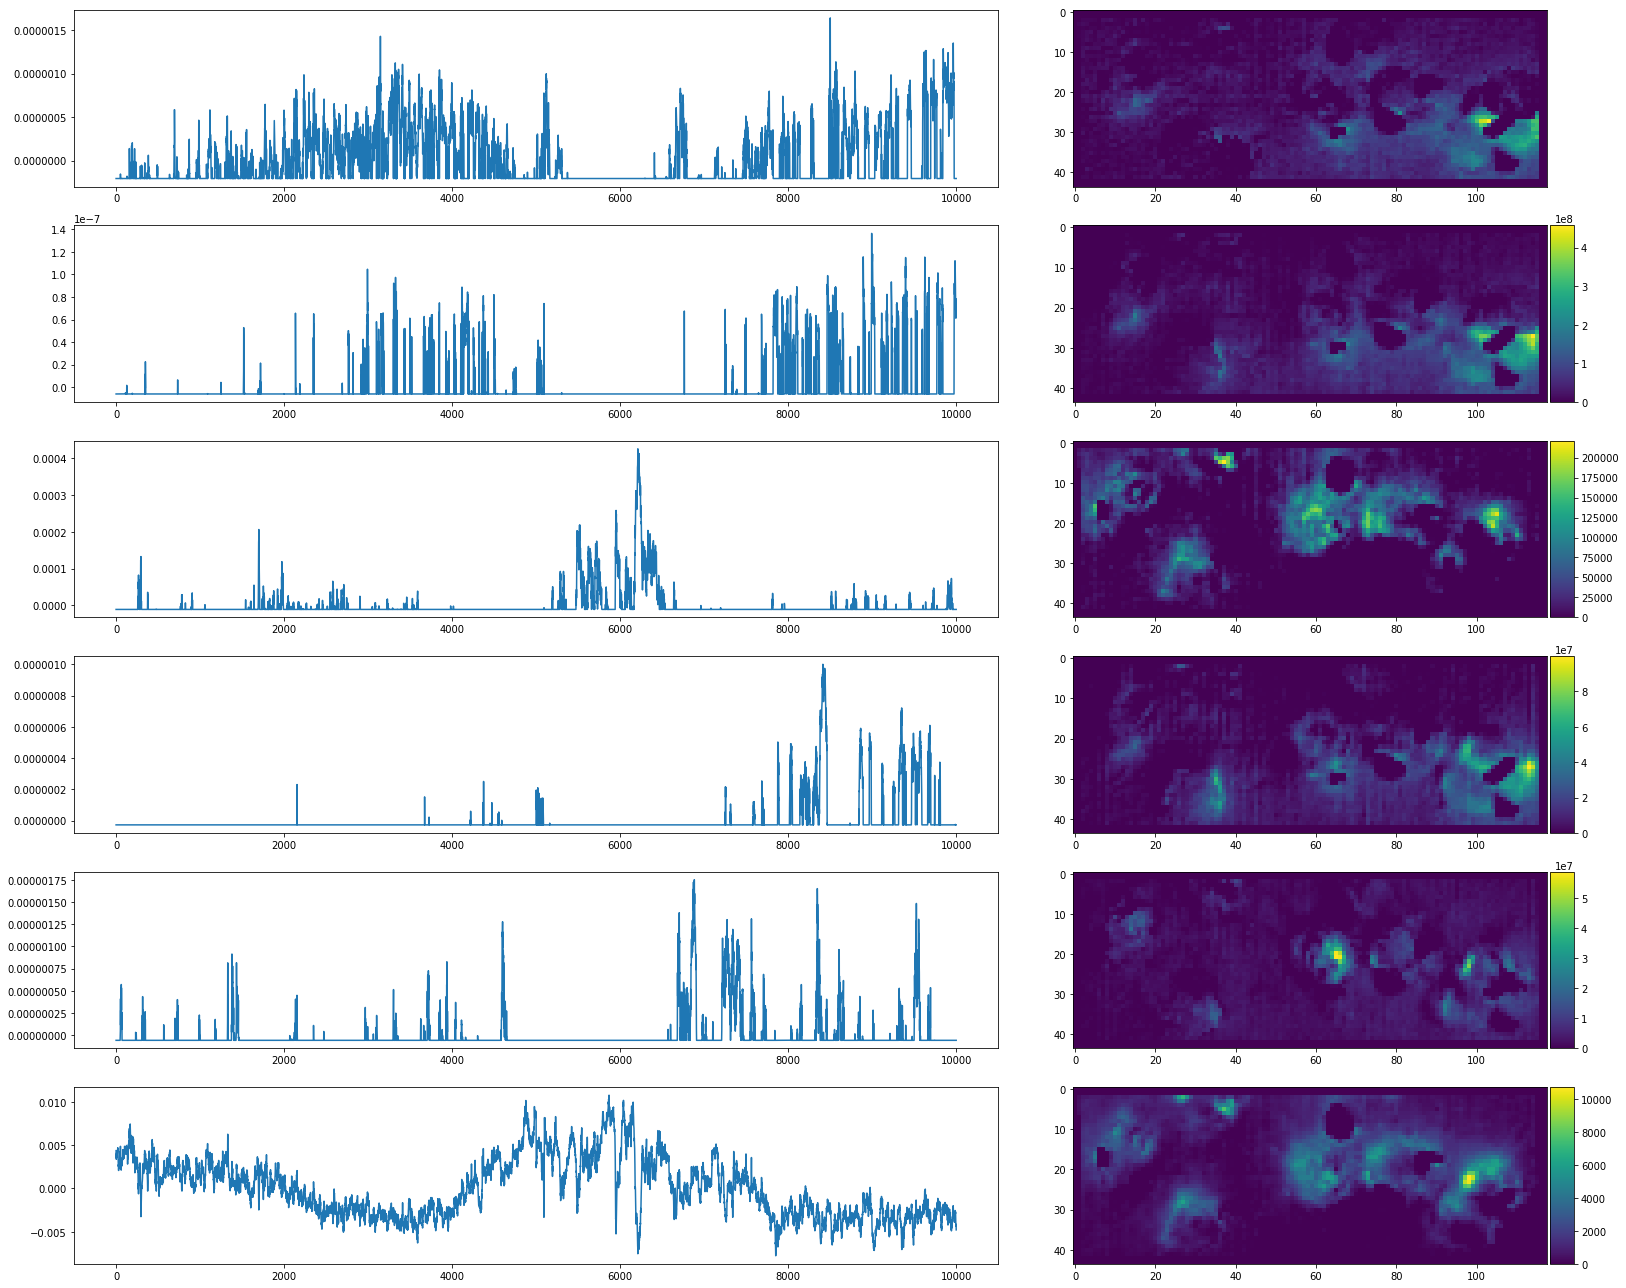

In [12]:
# plot all background traces and footprints
bg_rank = fb.shape[1]

plt.figure(figsize=(25,3*bg_rank))

for bkgd_num in range(bg_rank):
    plt.subplot(bg_rank,2,2*bkgd_num+1)
    plt.plot(ff[:,bkgd_num])
    
    bkgd_comp = fb[:,bkgd_num].reshape(movB.shape[1::-1]).transpose(1,0)
    plt.subplot(bg_rank,2,2*bkgd_num+2)
    io.imshow(bkgd_comp)

In [13]:
proc = input('Ok to proceed? (y/n) ')

if proc.lower() == 'n':
    raise KeyboardInterrupt('Stop requested by user.')

Ok to proceed? (y/n) y


## Choose Cells and Recover Temporal Correlation Structures

In [14]:
final_cells = range(7)

nCells = len(final_cells)

Y = movB.transpose(1,0,2).reshape(movB.shape[0] * movB.shape[1], movB.shape[2])
X = np.hstack((a * c[300,:],
               fb * ff[300,:]))

w = np.linalg.lstsq(np.hstack((X[:,final_cells],np.ones(X[:,:1].shape))), X[:,-bg_rank:])[0]

X2 = np.zeros((X.shape[0],nCells + bg_rank))
X2[:,:nCells] = X[:,final_cells]
X2[:,nCells:] = X[:,-bg_rank:] - X[:,final_cells] @ w[:nCells,:]

/n/home00/mxie/.conda/envs/michaelxie/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


## Reload Trend (Skip if not using Optopatch Stim)

In [15]:
proc = input('Do you want to load a trend? (y/n) ');

if proc.lower() == 'y':
    trend = io.imread(path + '/trend.tif')
    plt.imshow(np.mean(trend,axis=2))
    trendB = trend.reshape(int(trend.shape[0]/2),2,int(trend.shape[1]/2),2,trend.shape[2])
    trendB = np.mean(np.mean(trendB,axis=1),axis=2)
    trendB.shape

    Y = (movB+trendB).transpose(1,0,2).reshape(movB.shape[0] * movB.shape[1], movB.shape[2])
    print('Trend reloaded!')

Do you want to load a trend? (y/n) n


## Get Final Traces

In [16]:
beta_hat2 = np.linalg.lstsq(X2, Y)[0]
res = np.mean(np.square(Y - X2 @ beta_hat2),axis = 0)

/n/home00/mxie/.conda/envs/michaelxie/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


## Visualizations

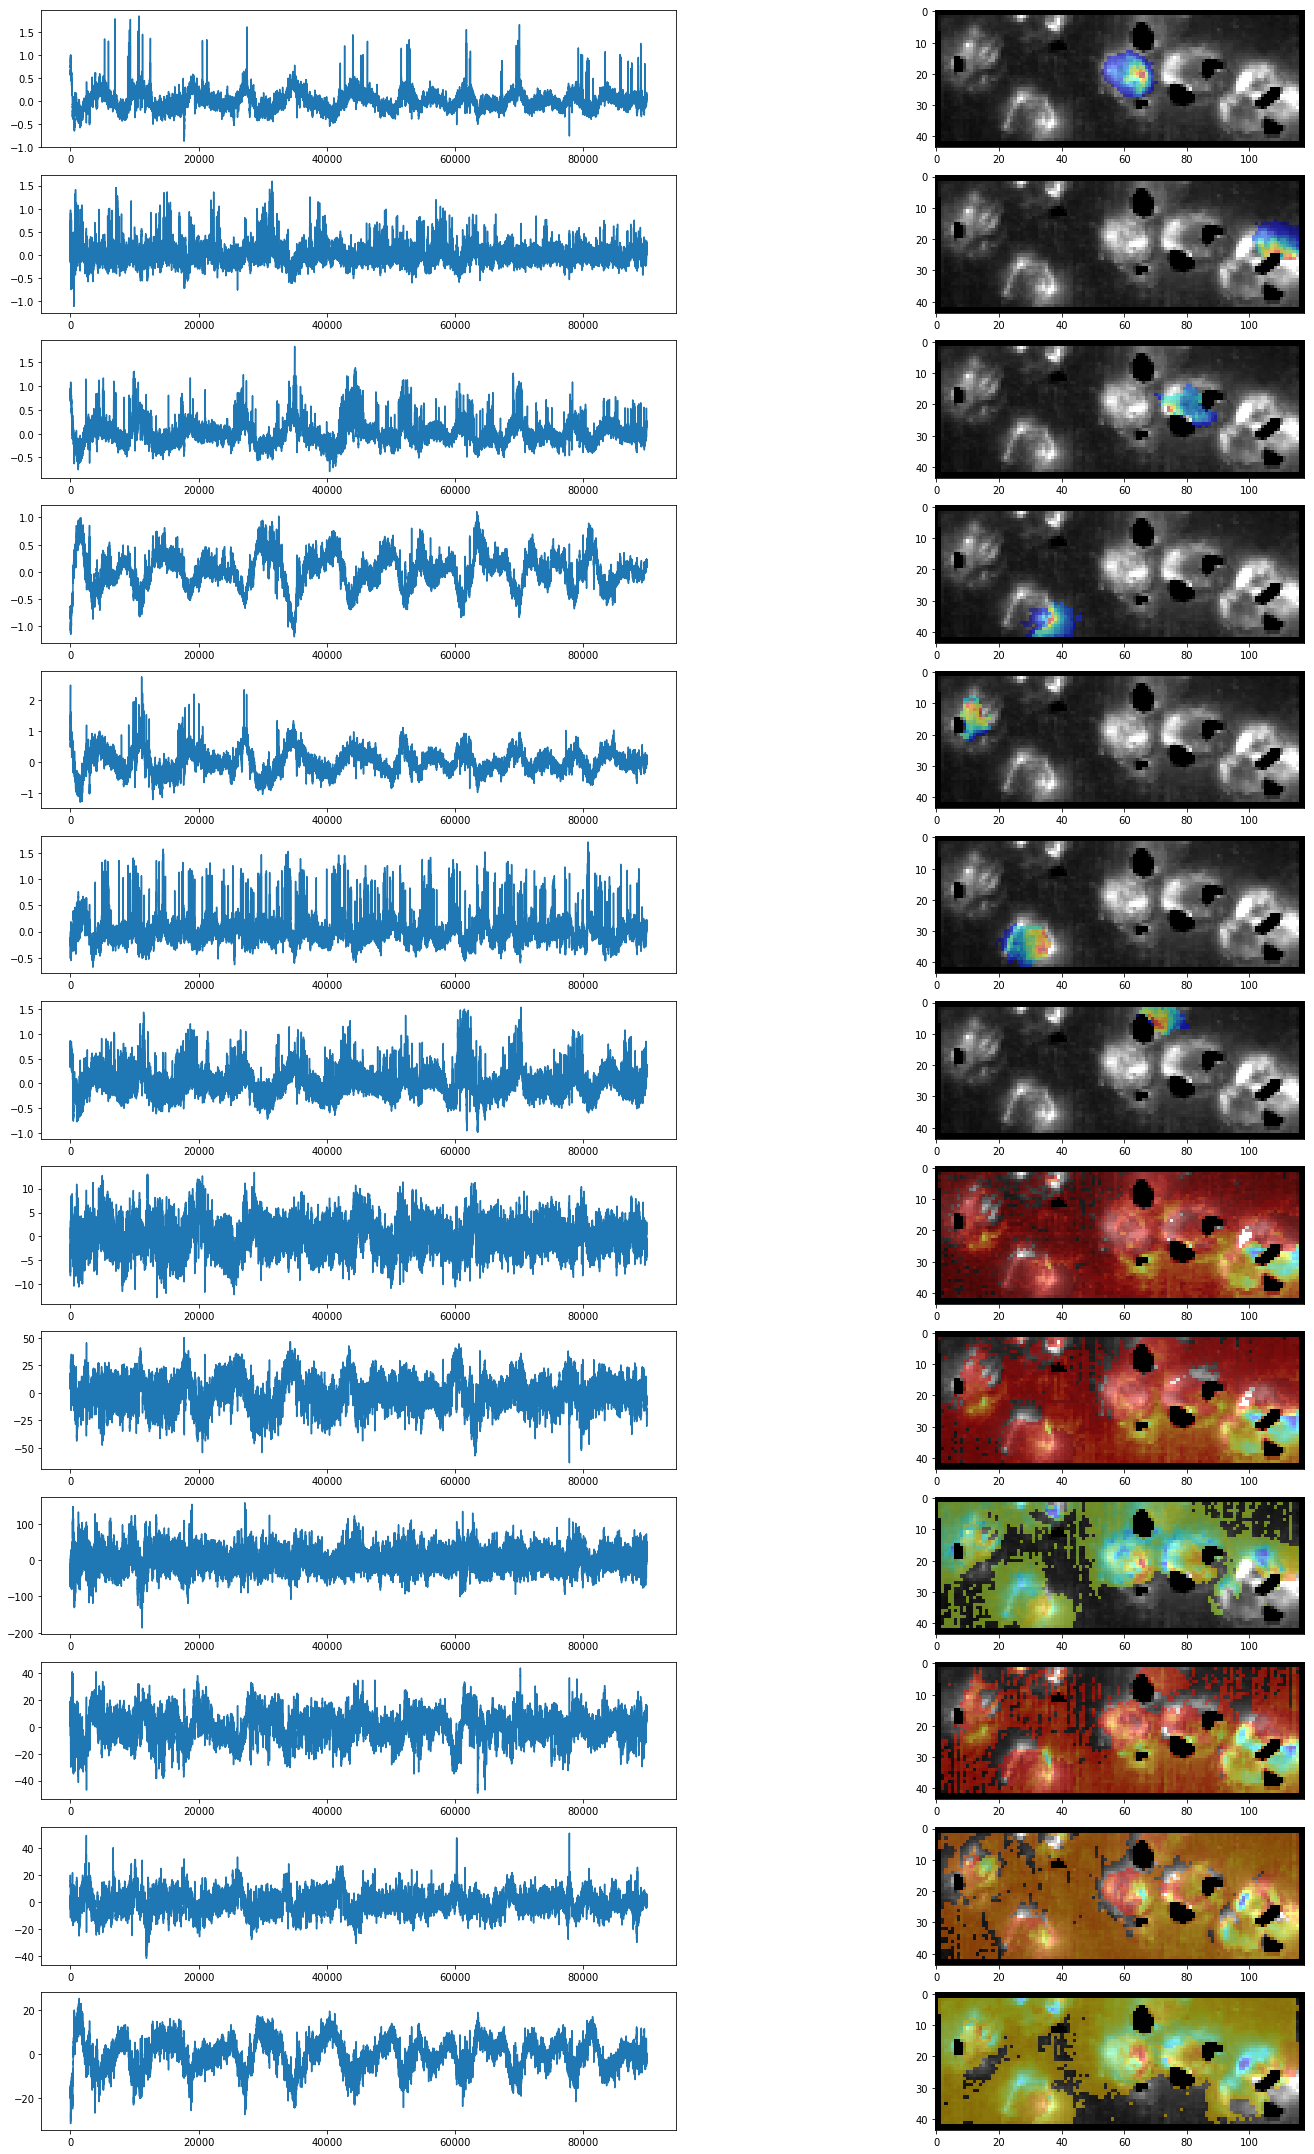

In [17]:
num_traces = beta_hat2.shape[0]
plt.figure(figsize=(25,3*num_traces))
ref_im = np.std(movB,axis=2)#.transpose(1,0)

for idx in range(num_traces):
    plt.subplot(num_traces,2,2*idx+1)
    plt.plot(beta_hat2[idx,:])
    
    plt.subplot(num_traces,2,2*idx+2)
    lower,upper = np.percentile(ref_im.flatten(),[1, 99])
    plt.imshow(ref_im,cmap='gray',interpolation='none',clim=[lower,upper])
    
    cell_loc = X2[:,idx].reshape(movB.shape[1::-1]).transpose(1,0)
    cell_loc = np.ma.masked_where(abs(cell_loc) < 1e-8, cell_loc)
    plt.imshow(cell_loc,cmap='jet',alpha=0.5)

## Save Results

In [18]:
proc = input('Do you want to save out results? (y/n) ');

if proc.lower() == 'y':
    suffix = ''

    io.imsave(path + '/spatial_footprints'+suffix+'.tif', X2)
    io.imsave(path + '/cell_spatial_footprints'+suffix+'.tif', X2[:,:nCells])
    io.imsave(path + '/temporal_traces'+suffix+'.tif', beta_hat2)
    io.imsave(path + '/cell_traces'+suffix+'.tif', beta_hat2[:nCells,:])
    io.imsave(path + '/residual_var'+suffix+'.tif', res)

    cell_locations = center_of_mass(X2[:,0].reshape(movB.shape[1::-1]).transpose(1,0))
    for idx in range(nCells - 1):
        cell_locations = np.vstack((cell_locations, 
                                    center_of_mass(X2[:, idx + 1].reshape(movB.shape[1::-1]).transpose(1,0))))
    io.imsave(path + '/cell_locations'+suffix+'.tif', np.array(cell_locations))

    if nCells > 1:
        io.imsave(path + '/cell_demixing_matrix'+suffix+'.tif', 
                  np.linalg.inv(np.array(X2[:,:nCells].T @ X2[:,:nCells])) @ X2[:,:nCells].T)
    print('Saved!')

Do you want to save out results? (y/n) n
